In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm

In [2]:
# Define transformations (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # Scale to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 460kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.66MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
import torch

class UNetMNIST(torch.nn.Module):
    """U-Net architecture for MNIST image processing with SiLU activation"""
    
    def __init__(self):
        super().__init__()
        # Define channel dimensions for the network
        chs = [32, 64, 128, 256, 256]
        
        # Encoder (downsampling) path
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(1, chs[0], kernel_size=3, padding=1),  # (batch, 32, 28, 28)
                torch.nn.SiLU(),
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, 32, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, 64, 14, 14)
                torch.nn.SiLU(),
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, 64, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, 128, 7, 7)
                torch.nn.SiLU(),
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, 128, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, 256, 4, 4)
                torch.nn.SiLU(),
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, 256, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, 256, 2, 2)
                torch.nn.SiLU(),
            ),
        ])
        
        # Decoder (upsampling) path
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # Input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 256, 4, 4)
                torch.nn.SiLU(),
            ),
            torch.nn.Sequential(
                # Input is the output from the above sequential concatenated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 128, 7, 7)
                torch.nn.SiLU(),
            ),
            torch.nn.Sequential(
                # Input is the output from the above sequential concatenated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 14, 14)
                torch.nn.SiLU(),
            ),
            torch.nn.Sequential(
                # Input is the output from the above sequential concatenated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 32, 28, 28)
                torch.nn.SiLU(),
            ),
            torch.nn.Sequential(
                # Input is the output from the above sequential concatenated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, 32, 28, 28)
                torch.nn.SiLU(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch, 1, 28, 28)
            
        Returns:
            Output tensor of shape (batch, 1, 28, 28)
        """
        # Encoder path, store intermediate outputs for skip connections
        signal = x
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)
        
        # Decoder path with skip connections
        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                # Connect with corresponding encoder output (skip connection)
                signal = torch.cat((signal, signals[-i]), dim=1)  # Concatenate along channel dimension
                signal = tconv(signal)
                
        return signal

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 20
lr = 1e-4
sigma = 0.7

model = UNetMNIST()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [5]:
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    
    for x, _ in progress_bar:
        x = x.to(device)
        y = x + sigma * torch.randn_like(x)
        
        scores = model(y)
        x_hat = y + scores*(sigma**2)
        loss = F.mse_loss(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.2f}")

Epoch 1/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.10


Epoch 2/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/20, Loss: 0.04


Epoch 3/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/20, Loss: 0.03


Epoch 4/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/20, Loss: 0.03


Epoch 5/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/20, Loss: 0.03


Epoch 6/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/20, Loss: 0.02


Epoch 7/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/20, Loss: 0.02


Epoch 8/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/20, Loss: 0.02


Epoch 9/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/20, Loss: 0.02


Epoch 10/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/20, Loss: 0.02


Epoch 11/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11/20, Loss: 0.02


Epoch 12/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/20, Loss: 0.02


Epoch 13/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/20, Loss: 0.02


Epoch 14/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/20, Loss: 0.02


Epoch 15/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/20, Loss: 0.02


Epoch 16/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16/20, Loss: 0.02


Epoch 17/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17/20, Loss: 0.02


Epoch 18/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18/20, Loss: 0.02


Epoch 19/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19/20, Loss: 0.02


Epoch 20/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20/20, Loss: 0.02


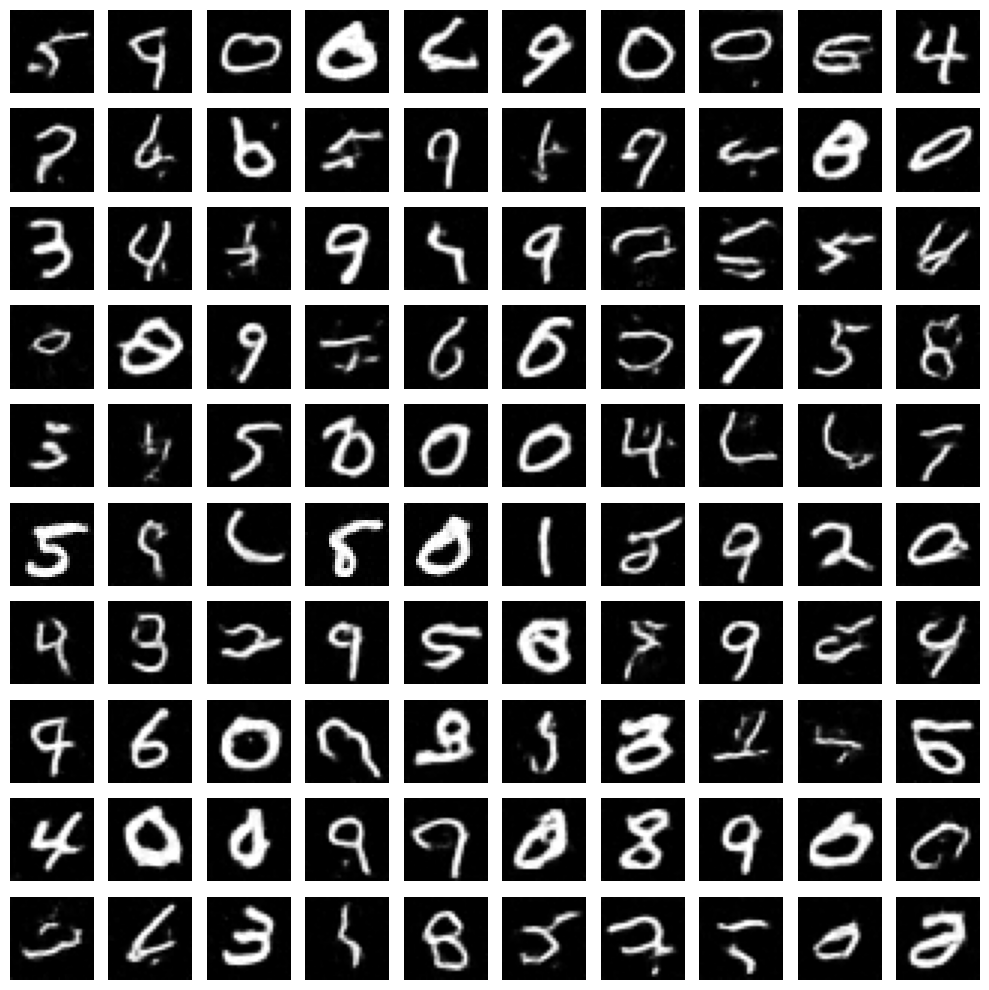

In [6]:
model.eval()
tau = 0.2
y = torch.randn(100, 1, 28, 28, device=device)
burn_in = 300
n_samples = 1
samples = []

with torch.no_grad():
    for _ in range(burn_in):
        y = y + tau * model(y) + (2 * tau) ** 0.5 * torch.randn_like(y)

    for _ in range(n_samples):
        # Walk
        y = y + tau * model(y) + (2 * tau) ** 0.5 * torch.randn_like(y)
        # Jump
        x_hat = y + model(y)*(sigma**2)

        samples.append(x_hat.cpu())

samples = torch.cat(samples, dim=0)

fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# Loop through the grid and plot images
for i in range(10):
    for j in range(10):
        img = samples[i * 10 + j, 0]  # Select the image from the batch
        ax = axes[i, j]
        ax.imshow(img, vmin=-1, vmax=1, cmap="gray")
        ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()